# predict_future_output 

## Goal: given the output history of a gun, predict a range on the future of it's inputs


In [1]:
input_file = "dataset1_clean.csv"

In [24]:
# imports:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
# import utils and other models
import utils
import bla_avg_model

In [3]:
# load in cleaned dataset
data = pd.read_csv(input_file, index_col=[0], skipinitialspace=True)
print(data.head())

                     DAC_S0_95th_quantile  DAC_S0_median  DAC_S0_5th_quantile  \
Time                                                                            
1900-01-01 00:00:00                   2.0            2.0                  2.0   
1900-01-01 00:01:00                   2.0            2.0                  2.0   
1900-01-01 00:02:00                   2.0            2.0                  2.0   
1900-01-01 00:03:00                   2.0            2.0                  2.0   
1900-01-01 00:04:00                   2.0            2.0                  2.0   

                     SO_(volts)_95th_quantile  SO_(volts)_median  \
Time                                                               
1900-01-01 00:00:00                       2.0                2.0   
1900-01-01 00:01:00                       2.0                2.0   
1900-01-01 00:02:00                       2.0                2.0   
1900-01-01 00:03:00                       2.0                2.0   
1900-01-01 00:04:00     

In [4]:
print(data.iloc[-1])

DAC_S0_95th_quantile         2.0000
DAC_S0_median                2.0000
DAC_S0_5th_quantile          2.0000
SO_(volts)_95th_quantile     2.0000
SO_(volts)_median            2.0000
                             ...   
BLA_5_median               -33.4500
BLA_5_5th_quantile         -33.3900
BLA_6_95th_quantile        -33.3315
BLA_6_median               -33.2000
BLA_6_5th_quantile         -33.1100
Name: 1900-01-09 23:59:00, Length: 141, dtype: float64


In [5]:
# (year set to 1900 since that is the base for datetime objects)
# note date ranges are not inclusive
train_date_range = ["1900-01-01", "1900-01-08"]
test_date_range = ["1900-01-08", "1900-01-10"]

full_train, test = utils.split_by_day(data, train_date_range, test_date_range)

print(full_train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 10080 entries, 1900-01-01 00:00:00 to 1900-01-07 23:59:00
Columns: 141 entries, DAC_S0_95th_quantile to BLA_6_5th_quantile
dtypes: float64(141)
memory usage: 10.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 2841 entries, 1900-01-08 00:00:00 to 1900-01-09 23:59:00
Columns: 141 entries, DAC_S0_95th_quantile to BLA_6_5th_quantile
dtypes: float64(141)
memory usage: 3.1+ MB
None


In [6]:
# split full_train into a train and valdiation set
validation_frac = .1
train, validation = train_test_split(full_train, test_size=validation_frac)
print(validation.info())
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1008 entries, 1900-01-01 02:30:00 to 1900-01-02 15:13:00
Columns: 141 entries, DAC_S0_95th_quantile to BLA_6_5th_quantile
dtypes: float64(141)
memory usage: 1.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 9072 entries, 1900-01-05 19:12:00 to 1900-01-01 23:04:00
Columns: 141 entries, DAC_S0_95th_quantile to BLA_6_5th_quantile
dtypes: float64(141)
memory usage: 9.8+ MB
None


In [7]:
# convert the train and validation dataframes into a set of np arrays that can be more readily used to train models
train_X_95th, train_X_median, train_X_5th = utils.split_X_into_quantiles(train)
train_Y_95th, train_Y_median, train_Y_5th = utils.split_Y_into_beams_and_quantiles(train)

validation_X_95th, validation_X_median, validation_X_5th = utils.split_X_into_quantiles(validation)
validation_Y_95th, validation_Y_median, validation_Y_5th = utils.split_Y_into_beams_and_quantiles(validation)

In [8]:
print(train_X_median.shape)

(9072, 41)


In [9]:
print(train.columns)

Index(['DAC_S0_95th_quantile', 'DAC_S0_median', 'DAC_S0_5th_quantile',
       'SO_(volts)_95th_quantile', 'SO_(volts)_median',
       'SO_(volts)_5th_quantile', 'DAC_S1_95th_quantile', 'DAC_S1_median',
       'DAC_S1_5th_quantile', 'S1_(volts)_95th_quantile',
       ...
       'BLA_3_5th_quantile', 'BLA_4_95th_quantile', 'BLA_4_median',
       'BLA_4_5th_quantile', 'BLA_5_95th_quantile', 'BLA_5_median',
       'BLA_5_5th_quantile', 'BLA_6_95th_quantile', 'BLA_6_median',
       'BLA_6_5th_quantile'],
      dtype='object', length=141)


In [10]:
# defining some evaluation metrics
def prop_within_bounds(actual, pred_95th, pred_5th):
    # return the proportion of points in actual that fall between the predicted 5th and 95th quantiles
    num_points = actual.shape[0]
    within_upper = actual > pred_95th
    within_lower = actual < pred_5th
    within_range = np.logical_and(within_upper, within_lower)
    #print(within_range)
    
    return np.count_nonzero(within_range) / num_points

In [11]:
# Train baseline model: BlaAvgModel
# this model ignores differences in beams and tries to fit a single model to every beam by averaging the output from all
# beams before fitting a model
model_95 = bla_avg_model.BlaAvgModel()
model_median = bla_avg_model.BlaAvgModel()
model_5 = bla_avg_model.BlaAvgModel()

model_95.train(train_X_median, train_Y_95th)
model_median.train(train_X_median, train_Y_median)
model_5.train(train_X_median, train_Y_5th)

pred_95 = model_95.predict(validation_X_median)
pred_median = model_median.predict(validation_X_median)
pred_5 = model_5.predict(validation_X_median)

6
6
6


In [12]:
props = []
for i in range(6):
    p = prop_within_bounds(validation_Y_median[i], pred_95, pred_5)
    props.append(p)
    
print(props)

[0.0, 0.0, 0.0, 0.0, 0.4037698412698413, 0.0]


In [13]:
print(validation_Y_median[0].shape)
print(pred_95.shape)
#print(pred_95)
print(pred_5.shape)

(1008, 1)
(1008, 1)
(1008, 1)


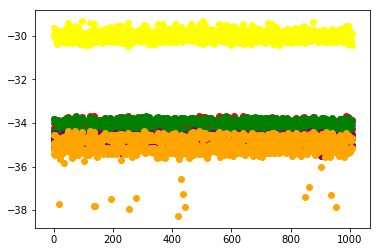

In [22]:
scatter_indices = list(range(len(pred_95)))
#plt.plot(pred_95, color="Blue")
plt.scatter(scatter_indices, pred_95, label="95th")
plt.scatter(scatter_indices, pred_5, c="Red", label="5th")
plt.scatter(scatter_indices, validation_Y_median[0], c="Yellow", label="median")
plt.scatter(scatter_indices, validation_Y_median[4], c="Green", label="median")
plt.scatter(scatter_indices, validation_Y_median[1], c="Purple", label="median")
plt.scatter(scatter_indices, validation_Y_median[2], c="Orange", label="median")
plt.show()

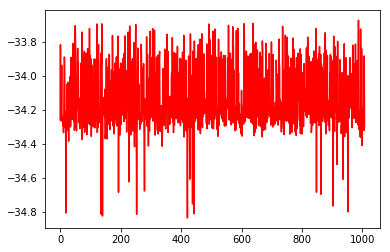

In [15]:
plt.plot(pred_5, color="Red")
plt.show()



In [16]:
# evaluate models:
# split test set into a set of np arrays that can be more readily used to generate model predictions
test_X_95th, test_X_median, test_X_5th = utils.split_X_into_quantiles(test)
test_Y_95th, test_Y_median, test_Y_5th = utils.split_Y_into_beams_and_quantiles(test)